# I want to know how different ML techniques predict linear & nonlinear dynamic system timeseries. Networks include multi-layer perceptrons, convolution, recurrent, residual, dense, and parseval networks. 
## Other ML methods include Gaussian Processes and interpretation methods, like layer-wise propagation or LIME.

In [1]:
import torch
import math
import gpytorch 
from matplotlib import pyplot as plt

### Generate training data

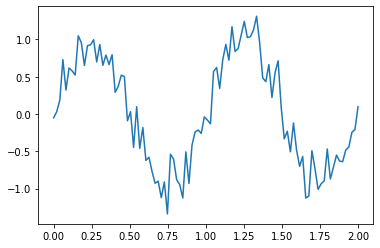

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 2, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

plt.plot(train_x,train_y)
plt.show()

### initialize

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### train

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

training_iter = 50

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.960   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.930   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.897   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.859   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.816   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.766   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.712   lengthscale: 0.440   noise: 0.437
Iter 8/50 - Loss: 0.656   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.602   lengthscale: 0.373   noise: 0.369
Iter 10/50 - Loss: 0.553   lengthscale: 0.343   noise: 0.339
Iter 11/50 - Loss: 0.509   lengthscale: 0.316   noise: 0.310
Iter 12/50 - Loss: 0.470   lengthscale: 0.292   noise: 0.283
Iter 13/50 - Loss: 0.433   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.398   lengthscale: 0.254   noise: 0.236
Iter 15/50 - Loss: 0.365   lengthscale: 0.240   noise: 0.215
Iter 16/50 - Loss: 0.331   lengthscale: 0.229   noise: 0.196
Iter 17/50 - Loss: 0.299   length

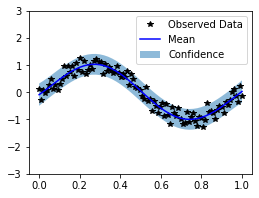

In [15]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix